In [2]:
import numpy as np
import scipy
import tqdm

In [3]:
records = {
    'still':'/Users/liyutong/projectExchange/imu-python-tools/hipnuc_mem/hipnuc_data_20211201_202828_still.npz',
    'manual_still': '/Users/liyutong/projectExchange/imu-python-tools/hipnuc_mem/hipnuc_data_20211201_203737_manual_still.npz',
    'slow_move':'/Users/liyutong/projectExchange/imu-python-tools/hipnuc_mem/hipnuc_data_20211201_204307_slow_move.npz',
    'medium_move':'/Users/liyutong/projectExchange/imu-python-tools/hipnuc_mem/hipnuc_data_20211201_211126_medium_move.npz',
    'extreme_move':'/Users/liyutong/projectExchange/imu-python-tools/hipnuc_mem/hipnuc_data_20211201_211411_extreme.npz',
    'custom':'/Users/liyutong/projectExchange/imu-python-tools/hipnuc_mem/hipnuc_data_20211202_221604.npz'
}
records_npzfile = {key: np.load(records[key]) for key in records}

In [4]:
GRAVITY_NORM = 9.81


def unpack_npz(npzfile: np.ndarray, trim_thresh: int = 000, **kwargs):
    accel_i = np.squeeze(np.stack([npzfile['accel_x'], -1 * npzfile['accel_y'], npzfile['accel_z']], axis=1)).astype(
        np.float64) * GRAVITY_NORM
    gyro = np.squeeze(np.stack([npzfile['gyro_x'], -1 * npzfile['gyro_y'], npzfile['gyro_z']], axis=1)).astype(np.float64)
    rpy = np.squeeze(np.stack([npzfile['roll'], npzfile['pitch'], npzfile['yaw']], axis=1)).astype(np.float64) * np.pi / 180
    mag = np.squeeze(-np.stack([npzfile['mag_x'], -1 * npzfile['mag_y'], npzfile['mag_z']], axis=1)).astype(np.float64)
    timestamp = npzfile['timestamp'].astype(np.float64)

    # Trim
    if trim_thresh <= 0:
        trim_thresh = np.where(np.squeeze(npzfile['uart_buffer_len']) < 10)[0].min()

    accel_i = accel_i[trim_thresh:]
    gyro = gyro[trim_thresh:]
    rpy = rpy[trim_thresh:]
    mag = mag[trim_thresh:]
    timestamp = timestamp[trim_thresh:]
    return {'accel_i': accel_i, 'gyro': gyro, 'mag': mag, 'rpy': rpy, 'timestamp': timestamp}


def window_statistics(accel: np.ndarray, gyro: np.ndarray, window_sz: int, timestamp):
    res = {
        'gyro_mean': np.zeros_like(timestamp),
        'gyro_std': np.zeros_like(timestamp),
        'accel_mean': np.zeros_like(timestamp),
        'accel_std': np.zeros_like(timestamp),
    }

    with tqdm.tqdm(range(len(timestamp))) as pbar:
        for idx in range(1, len(timestamp) + 1):
            gyro_window = gyro[idx - window_sz:idx]
            accel_window = accel[idx - window_sz:idx]
            if gyro_window.shape[0] > 0 and accel_window.shape[0] > 0:
                res['gyro_mean'][idx - 1] = np.sqrt(np.sum(np.mean(gyro_window, axis=0)**2))
                res['gyro_std'][idx - 1] = np.mean(np.std(gyro_window, axis=0))

                res['accel_mean'][idx - 1] = np.sqrt(np.sum(np.mean(accel_window, axis=0)**2))
                res['accel_std'][idx - 1] = np.mean(np.std(accel_window, axis=0))
            pbar.update()

    return res

In [5]:
import matplotlib.pyplot as plt

def visualize_3d(data: np.ndarray, timestamp: np.ndarray, title: str):
    fig = plt.figure(figsize=(32, 8))

    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=timestamp)
    ax.set_xlabel(title + '-X', fontdict={'size': 15, 'color': 'red'})
    ax.set_ylabel(title + '-Y', fontdict={'size': 15, 'color': 'red'})
    ax.set_zlabel(title + '-Z', fontdict={'size': 15, 'color': 'red'})

    ax = fig.add_subplot(122)
    ax.scatter(timestamp, data[:, 0], s=2, c='r')
    ax.scatter(timestamp, data[:, 1], s=2, c='g')
    ax.scatter(timestamp, data[:, 2], s=2, c='b')
    ax.set_title(title)

    plt.show()


def visualize_1d(data: np.ndarray, timestamp: np.ndarray, title: str):
    fig = plt.figure(figsize=(10, 8))

    ax = fig.add_subplot(111)
    ax.scatter(timestamp, data, s=2)
    ax.set_title(title)
    # plt.gca().set_aspect('equal', adjustable='box')

    plt.show()


## For manual_still dataset

In [7]:
import tqdm
measurements = {key: unpack_npz(value) for key, value in records_npzfile.items()}

res = {key: window_statistics(measurement['accel_i'], measurement['gyro'], 10, timestamp=measurement['timestamp']) for key, measurement in measurements.items()}


# executor = ProcessPoolExecutor(max_workers=mp.cpu_count())

# all_task = {key: executor.submit(window_statistics,(measurement['accel_i'], measurement['gyro'], 5, measurement['timestamp'],)) for key, measurement in measurements.items()}

# for future in as_completed(all_task.values()):
#     future.result()

# res = {key: future.result() for key, future in all_task.items()}

100%|██████████| 737/737 [00:00<00:00, 25543.32it/s]


In [8]:
def plot_hist(res, name:str):
    FIG_HEIGHT = 4
    length = len(res)
    fig = plt.figure(figsize=(length*FIG_HEIGHT,4), dpi=100)
    fig.text(0.5,0,name)

    for idx, key in enumerate(res):
        ax = fig.add_subplot(100 + (length) * 10 + idx + 1)
        ax.hist(res[key][name], bins=np.linspace(res[key][name].min(),res[key][name].max(),101))
        ax.set_title(key)
    plt.show()

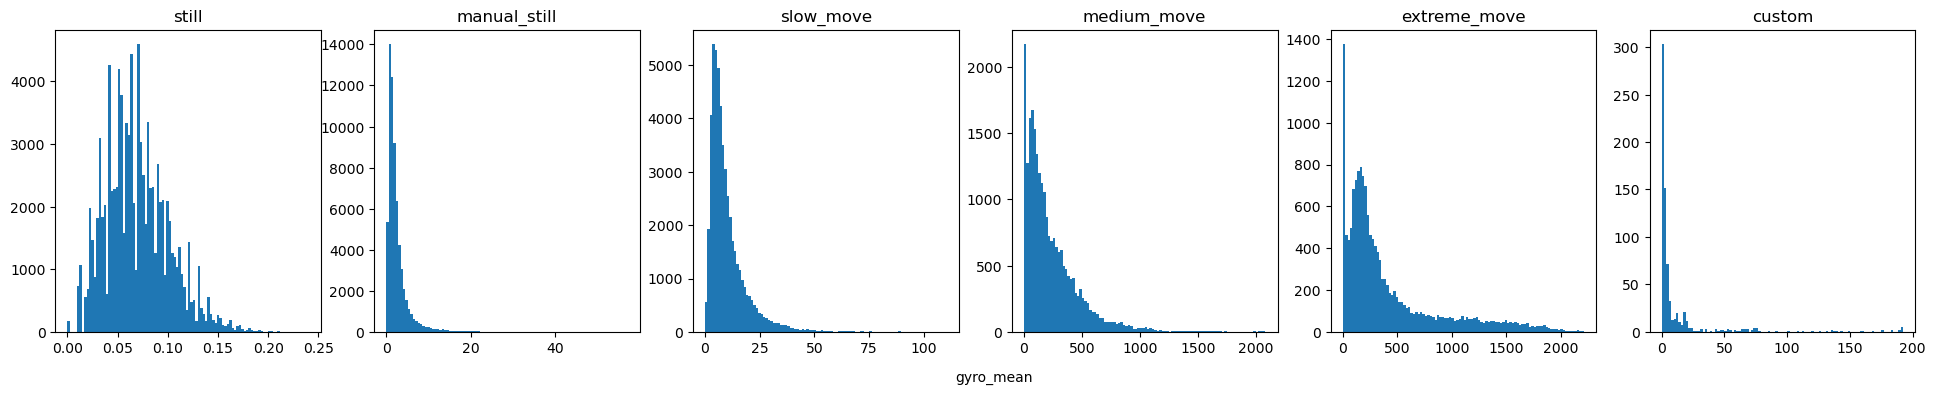

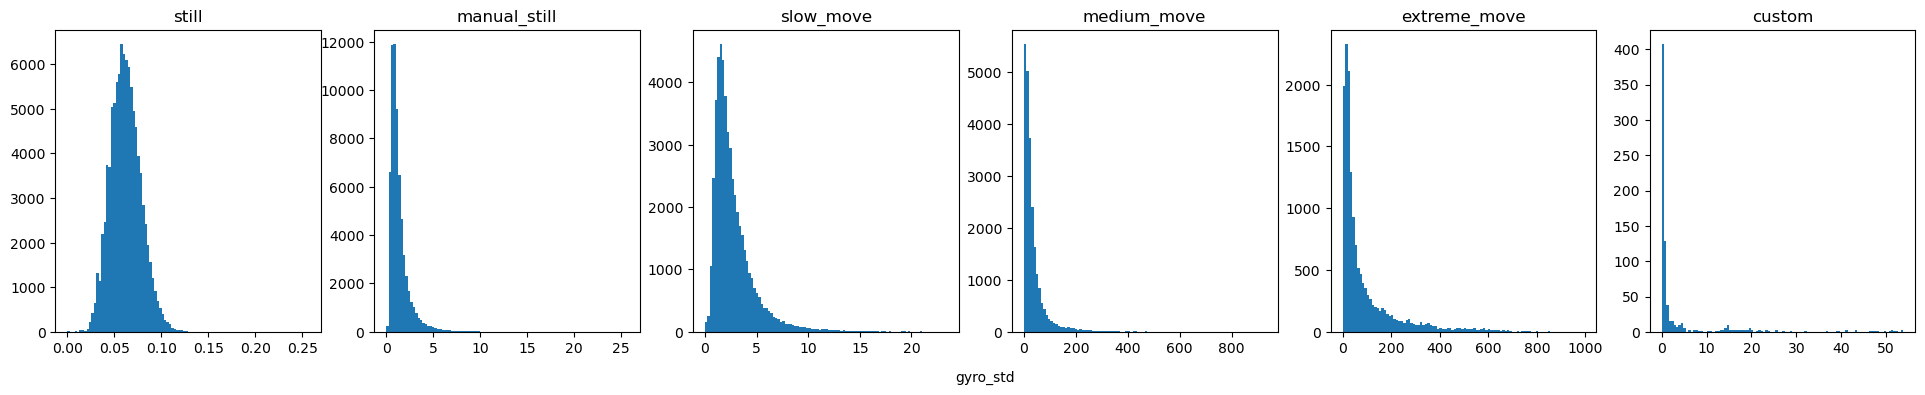

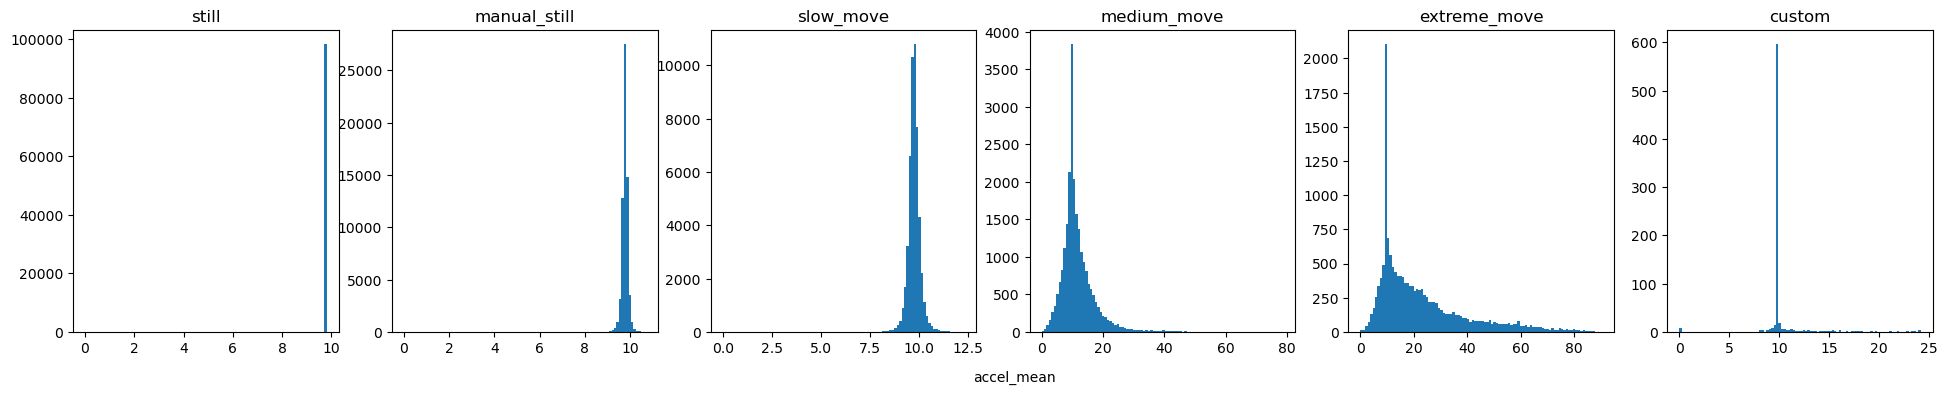

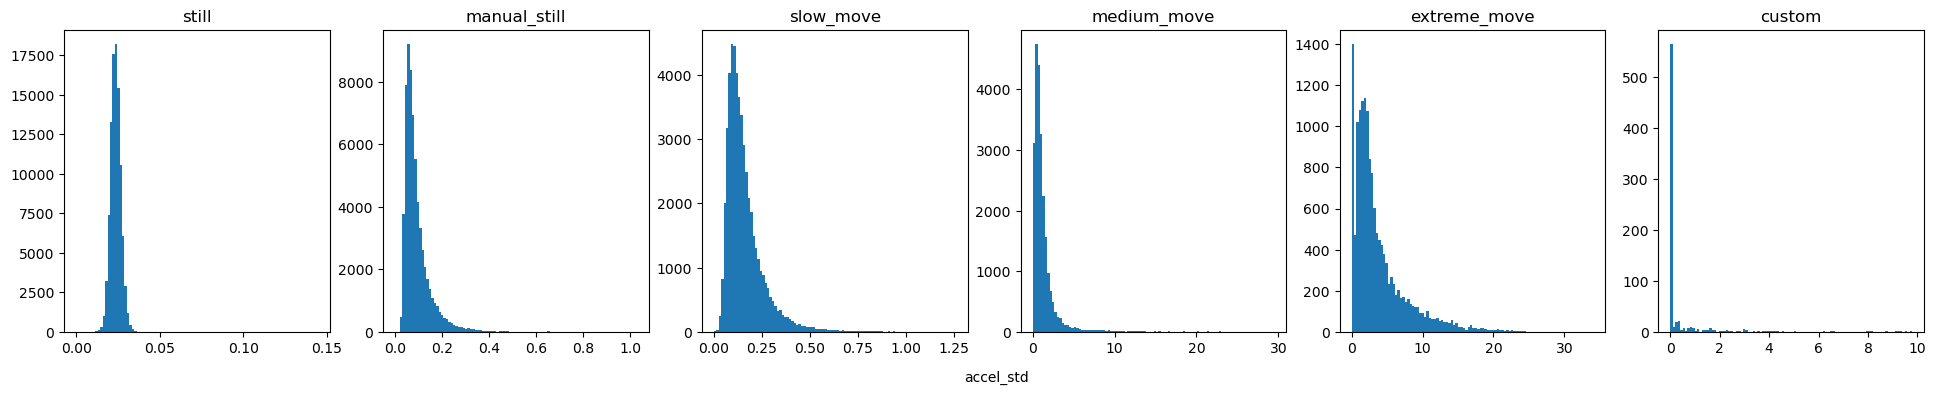

In [9]:
plot_hist(res, 'gyro_mean')
plot_hist(res, 'gyro_std')
plot_hist(res, 'accel_mean')
plot_hist(res, 'accel_std')


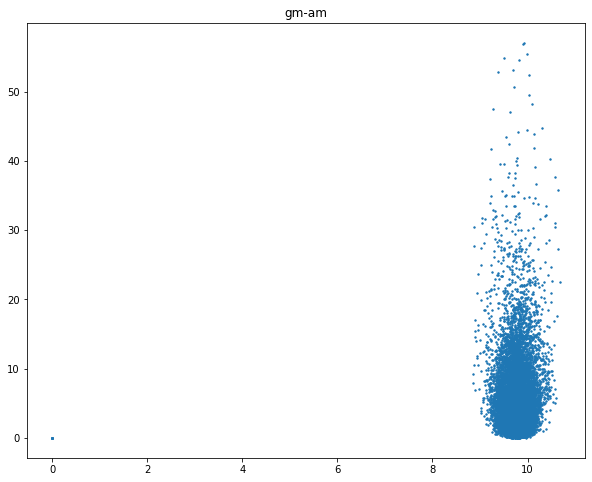

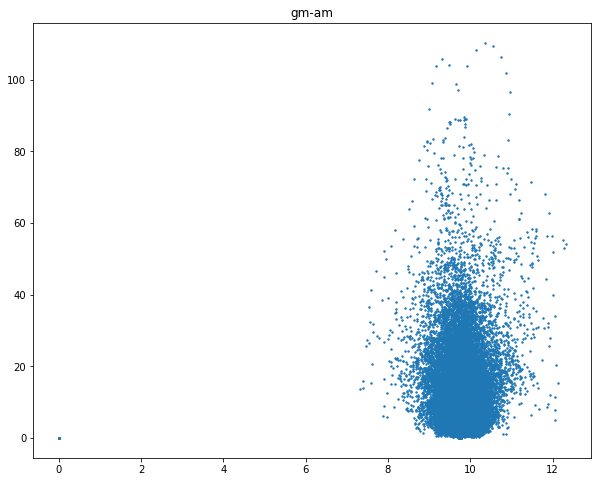

In [10]:
visualize_1d(res['manual_still']['gyro_mean'], res['manual_still']['accel_mean'], 'gm-am')
visualize_1d(res['slow_move']['gyro_mean'], res['slow_move']['accel_mean'], 'gm-am')